In [1]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import pandas as pd
import string

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import nltk
from nltk.corpus import stopwords
stopwords_fr = stopwords.words('french')
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer

# Créer un dictionnaire français à partir des mots français contenus dans la liste des mots français du corpus nltk
fr_dict = set(stopwords.words('french'))

2024-02-21 21:27:38.106555: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 21:27:38.106668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 21:27:38.227087: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv("/kaggle/input/french-twitter-sentiment-analysis/french_tweets.csv") #changer jusqu'a 50000 pour prendre les n premieres lignes -> eviter un bug
print(df.dtypes)
print(df.head())

label     int64
text     object
dtype: object
   label                                               text
0      0  - Awww, c'est un bummer. Tu devrais avoir davi...
1      0  Est contrarié qu'il ne puisse pas mettre à jou...
2      0  J'ai plongé plusieurs fois pour la balle. A ré...
3      0  Tout mon corps a des démangeaisons et comme si...
4      0  Non, il ne se comporte pas du tout. je suis en...


In [4]:
df_echantillon = df.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 500000)))

# Vérifiez la répartition des labels dans l'échantillon
repartition_labels = df_echantillon['label'].value_counts()
print(repartition_labels)

label
0    500000
1    500000
Name: count, dtype: int64


/tmp/ipykernel_34/1812069184.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_echantillon = df.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 500000)))


In [5]:
def clean_text(text):
    # lowercase
    text = text.lower()
    # remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    text= re.sub(r'[@/#]', '', text)
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    text = re.sub(r'_+', '', text)
    # Supprime les valeurs n'étant pas dans le bon alphabet
    text = re.sub(r'[^a-zA-ZÀ-ÿ\s]', '', text)
    #url
    text = re.sub(r'http\S+', '', text)
    # Supprime les valeurs vides
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


df_echantillon['text']=df_echantillon['text'].apply(clean_text)
df_echantillon['text'] = df_echantillon['text'].apply(remove_emoji)
df_echantillon.head()

,label,text
266165,0,j ai déjà manqué beaucoup de tweets de david
384409,0,sensationnel nous avons eu la tempête ici sans...
720955,0,je viens de sauver un bumble bee ça va être pi...
744194,0,iran gratuit r i p neda ma sur et dieu est le ...
77557,0,mes pieds hufrom essayant de casser ma nouvell...


In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_echantillon['text'])
X = tokenizer.texts_to_sequences(df_echantillon['text'])
X = pad_sequences(X)
y = np.array(df_echantillon['label'])
X = np.reshape(X, (X.shape[0],X.shape[1],1))
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Supposons que vous ayez des données textuelles dans une liste appelée "texts"
texts = df_echantillon['text'].tolist()

# Taille du vocabulaire
vocab_size = 1000  # Par exemple

# Taille de l'espace d'embedding
embedding_dim = 100  # Par exemple

# Créer un tokenizer
tokenizer = Tokenizer(num_words=vocab_size)

# Adapter le tokenizer sur les textes
tokenizer.fit_on_texts(texts)

# Convertir les textes en séquences d'entiers
sequences = tokenizer.texts_to_sequences(texts)

# Longueur maximale des séquences (à adapter en fonction de vos données)
max_len = 100  # Par exemple

# Obtenez la matrice des séquences
X = pad_sequences(sequences, maxlen=max_len)

# Données de sortie
y = np.array(df_echantillon['label'])

In [8]:
inputs = Input(shape=(max_len,))
# Couche d'embedding
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(inputs)

# Couches LSTM
x = LSTM(128, return_sequences=True)(embedding_layer)
x = Dropout(0.2)(x)
x = LSTM(64)(x)
x = Dropout(0.2)(x)

# Couche de sortie
outputs = Dense(1, activation='sigmoid')(x)

# Créer le modèle
model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 100)          100000    
                                                                 
 lstm (LSTM)                 (None, 100, 128)          117248    
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65    

In [9]:
learning_rate = 0.001  # Par exemple, vous pouvez choisir 0.001

# Créer un optimiseur Adam avec le learning rate spécifié
optimizer = Adam(learning_rate=learning_rate)

# Compiler le modèle avec l'optimiseur personnalisé
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Définir EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, restore_best_weights=True)

# Entraînement du modèle avec EarlyStopping et validation_split
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/30


I0000 00:00:1708551035.116290     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10000/10000 [==============================] - 129s 12ms/step - loss: 0.4946 - accuracy: 0.7574 - val_loss: 0.4765 - val_accuracy: 0.7700
Epoch 2/30
10000/10000 [==============================] - 108s 11ms/step - loss: 0.4725 - accuracy: 0.7715 - val_loss: 0.4692 - val_accuracy: 0.7745
Epoch 3/30
10000/10000 [==============================] - 107s 11ms/step - loss: 0.4620 - accuracy: 0.7781 - val_loss: 0.4635 - val_accuracy: 0.7780
Epoch 4/30
10000/10000 [==============================] - 107s 11ms/step - loss: 0.4528 - accuracy: 0.7837 - val_loss: 0.4582 - val_accuracy: 0.7814
Epoch 5/30
10000/10000 [==============================] - 107s 11ms/step - loss: 0.4443 - accuracy: 0.7887 - val_loss: 0.4584 - val_accuracy: 0.7808
Epoch 6/30
10000/10000 [==============================] - 107s 11ms/step - loss: 0.4358 - accuracy: 0.7936 - val_loss: 0.4583 - val_accuracy: 0.7809
Epoch 7/30
10000/10000 [==============================] - 107s 11ms/step - loss: 0.4271 - accuracy: 0.7983 - val_loss

In [10]:
# Évaluation du modèle
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

6250/6250 [==============================] - 31s 5ms/step - loss: 0.4604 - accuracy: 0.7789
Test Loss: 0.460418701171875
Test Accuracy: 0.7789250016212463


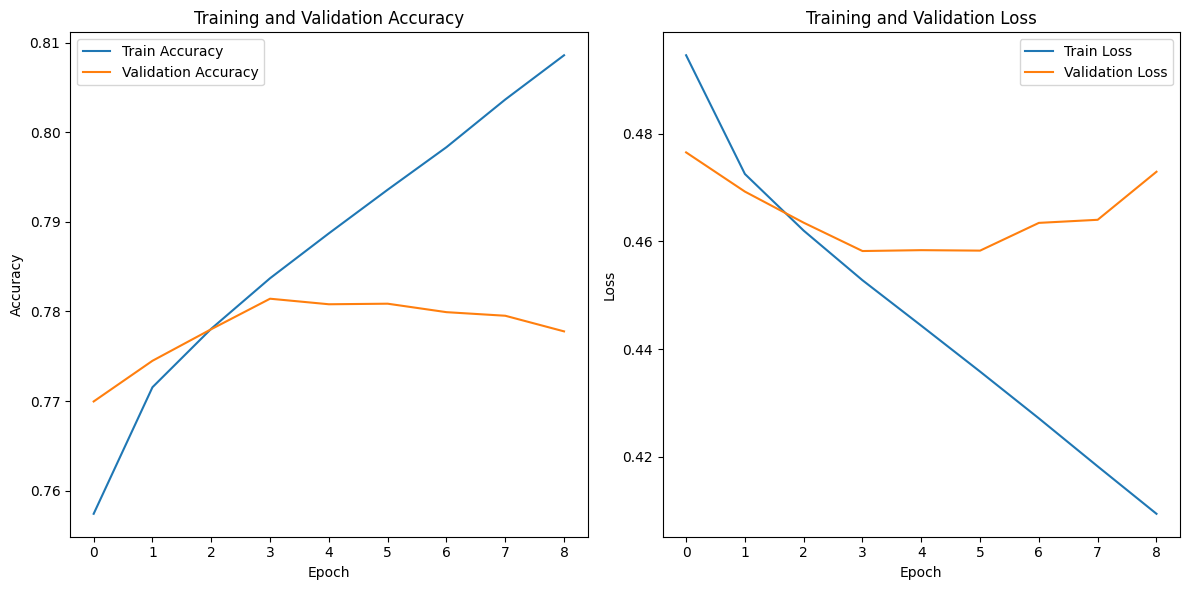

In [11]:
# Tracer les courbes d'accuracy et de perte
plt.figure(figsize=(12, 6))

# Courbe d'accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Courbe de perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

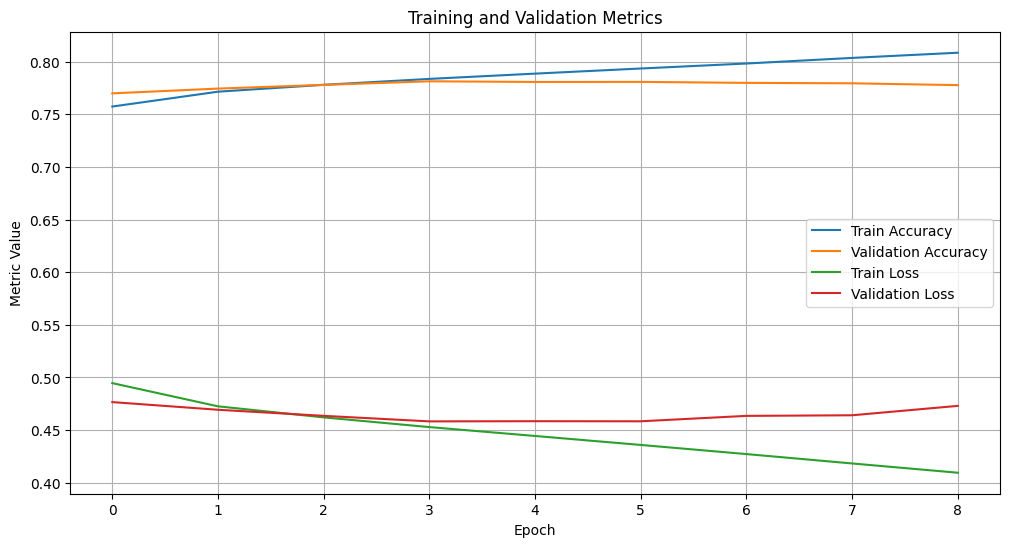

In [12]:
# Tracer les courbes d'accuracy et de perte
plt.figure(figsize=(12, 6))

# Courbe d'accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Courbe de perte
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()


6250/6250 [==============================] - 26s 4ms/step


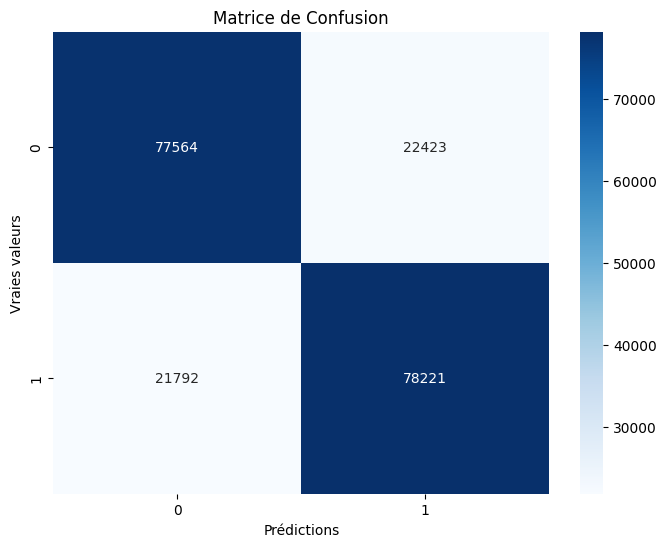

In [13]:
# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Visualiser la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()

In [14]:
# Sauvegarder le modèle
model.save("modele_de_base_grand.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
